# Entanglement Entropy

Recall the TFIM (and reuse that code for building/diagonalizing the Hamiltonian).

$H = -J\sum_{i=1}^{N-1} \sigma_{i}^{z}\sigma_{i+1}^{z} - J\sigma_{N}^{z}\sigma_{1}^{z} - h\sum_{i = 1}^{N}\sigma_{i}^{x}$

# Build the Hamiltonian

In [1]:
using SparseArrays

function Hamiltonian_TFIMPBC(N,J,h)
    
    dim = (2)^N
    H = zeros(dim,dim)
    magsZ = zeros(dim)
    
    for ket in (0:dim-1)
        
        ket_binary = bitstring(ket)
        Diagonal = Int64(0)
        
        for SpinIndex in (0:N-1) 
            
            magsZ[ket+1] += 2*((ket>>SpinIndex)&1)-1
            
            bit = Int(2)^(SpinIndex)
            bra = ket ⊻ bit
            H[bra+1,ket+1] += -h
            
            if SpinIndex == N-1
                S_last = 2*((ket>>SpinIndex)&1)-1
                S_first = 2*((ket>>(0))&1)-1
                Bond = J*S_last*S_first
                Diagonal += Bond
                break
            end
            
            Si = 2*((ket>>SpinIndex)&1)-1
            Si_next = 2*((ket>>(SpinIndex+1))&1)-1
            Bond = J*Si*Si_next
            Diagonal += Bond
            
        end
        
        H[ket+1,ket+1] += -1 * (Diagonal)
        
    end
    
    H_Sparse = H |> sparse
    
    return H_Sparse,magsZ
    
end

Hamiltonian_TFIMPBC (generic function with 1 method)

In [ ]:
using Arpack
N_ = 16
Ham, mags = Hamiltonian_TFIMPBC(N_,1,1)
gsE,gsWF = eigs(Ham, nev = 1, which=:SR)

In [ ]:
println("System Size = ",N_)
println("The Ground State Energy = ",gsE)
println("The length of the eigenvector = ",length(gsWF),", which is the dimension of the Hilbert space.")

In [ ]:
show(stdout,"text/plain",Ham)

# Build Density Matrix

We don't actually need to compute and store this density matrix (its huge). Instead, since we are working with sparse matrices, we can easily extract the elements that we will require.

We actually don't even need to use this...

In [ ]:
function make_rhoA(rho,A_spins)
    dim = length(rho[1,:])
    A_size = 2^A_spins
    B_size = Int(dim/A_size)
    reshaped = reshape(rho,(B_size,A_size,B_size,A_size))
    rhoA = zeros(A_size,A_size)
    for i in (1:A_size)
        for j in (1:A_size)
            current = reshaped[:,j,:,i]
            rhoA[j,i] = tr(current)
        end
    end
    return rhoA
end

# Calculate the Entanglement Entropy

In [2]:
using LinearAlgebra

function entropy(vec,N,N_A)
    dim = length(vec)
    #println("dim = ",dim)
    A_size = 2^N_A
    #println("A_spins = ",A_spins)
    #println("A_size = ",A_size)
    B_size = 2^(N-N_A) # 2^(N-N_A)
    #println("B_size should be... ",B_size)
    vec_reshaped = reshape(vec,(B_size,A_size))
    U,s,Vt= svd(vec_reshaped)
    S  = s.^2
    S_A = -S'*log.(S+0.0001*ones(length(S)))
    return S_A
end

entropy (generic function with 1 method)

In [ ]:
using Arpack
N_spins_TFIM = 16
x_range_TFIM = range(1,N_spins_TFIM-1,step = 1)
entropies_0 = zeros(length(x_range_TFIM))
entropies_1 = zeros(length(x_range_TFIM))
entropies_2 = zeros(length(x_range_TFIM))
ham0,mags0 = Hamiltonian_TFIMPBC(N_spins_TFIM,1,0)
val0,vec0 = eigs(ham0, nev = 1, which=:SR)
ham1,mags1 = Hamiltonian_TFIMPBC(N_spins_TFIM,1,1)
val1,vec1 = eigs(ham1, nev = 1, which=:SR)
ham2,mags2 = Hamiltonian_TFIMPBC(N_spins_TFIM,1,2)
val2,vec2 = eigs(ham2, nev = 1, which=:SR)

In [ ]:
for x in x_range_TFIM
    entropies_0[x] = entropy(vec0,N_spins_TFIM,x)
    entropies_1[x] = entropy(vec1,N_spins_TFIM,x)
    entropies_2[x] = entropy(vec2,N_spins_TFIM,x)
end

In [ ]:
using JLD2
save_object("NewData/entropies_TFIM_0",entropies_0)
save_object("NewData/entropies_TFIM_1",entropies_1)
save_object("NewData/entropies_TFIM_2",entropies_2)

In [3]:
using JLD2

entropies_0=load_object("NewData/entropies_TFIM_0")
entropies_1=load_object("NewData/entropies_TFIM_1")
entropies_2=load_object("NewData/entropies_TFIM_2");

In [4]:
using LsqFit

N_spins_TFIM = 16
x_range_TFIM = range(1,N_spins_TFIM-1,step = 1)
L = N_spins_TFIM
x_range = x_range_TFIM


model_TFIM1(t,p) = p[1].+ (p[2]/3).*log.(((L/pi).*sin.((pi.*t)./L)).+0.001)
tdata_TFIM = x_range_TFIM
ydata_TFIM = entropies_1
p0 = [1.,1.]
fit_TFIM= curve_fit(model_TFIM1,tdata_TFIM,ydata_TFIM,p0)
params_TFIM = fit_TFIM.param

2-element Vector{Float64}:
 0.4749226775379344
 0.5065405285968456

In [5]:
println(params_TFIM)
println(standard_errors(fit_TFIM))

[0.4749226775379344, 0.5065405285968456]
[0.0004575304659086741, 0.0011052574111131456]


In [6]:
x_range_TFIM_cont = range(1,L-1,step = .01)
fit_TFIM_cont = params_TFIM[1].+ (params_TFIM[2]/3).*log.(((L/pi).*sin.((pi.*x_range_TFIM_cont)./L)).+0.001);

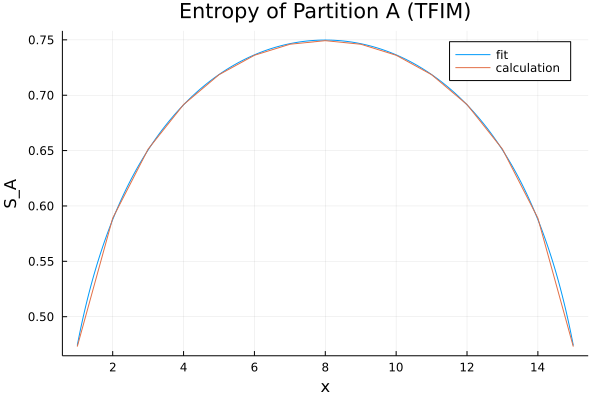

In [7]:
using Plots

plot(title = "Entropy of Partition A (TFIM)", xlabel = "x", ylabel = "S_A")

plot!(x_range_TFIM_cont,fit_TFIM_cont,label = "fit")

display(plot!(x_range_TFIM,entropies_1,label = "calculation"))

In [ ]:
png("NewPlots/SA_TFIM_1_fit")

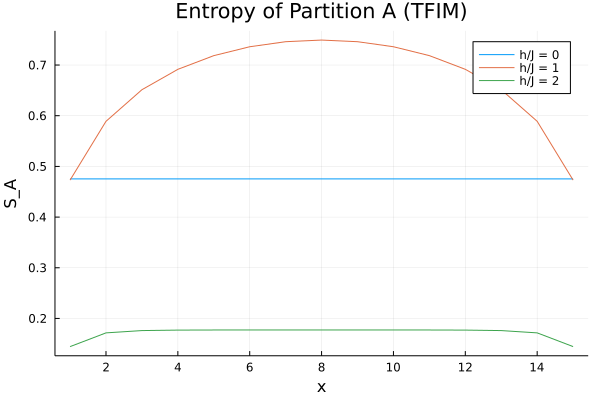

In [8]:
using Plots

plot(title = "Entropy of Partition A (TFIM)", xlabel = "x", ylabel = "S_A")

plot!(x_range_TFIM,entropies_0,label = "h/J = 0")
plot!(x_range_TFIM,entropies_1,label = "h/J = 1")
display(plot!(x_range_TFIM,entropies_2,label = "h/J = 2"))

In [ ]:
png("NewPlots/SA_TFIM_allhJ")

# Build the other Hamiltonians

In [9]:
using SparseArrays

function Hamiltonian_Prob2(N,Delta,J_perp)
    
    dim = (2)^N
    H = zeros(dim,dim)
    magz = zeros(dim)
    
    for ket in (0:dim-1)
        
        ket_binary = bitstring(ket)
        Diagonal = Int64(0)
        
        for SpinIndex in (0:N-1) 
            
            magz[ket+1] += 2*((ket>>SpinIndex)&1)-1
            
            if SpinIndex == N-1
                
                bit_last = Int(2)^(SpinIndex)
                bit_first = Int(2)^(0)
                flipbit_last = ket ⊻ bit_last
                flipbit_first  = flipbit_last ⊻ bit_first
                Sy_flip_last = (2*((flipbit_first>>SpinIndex)&1)-1)im
                Sy_flip_first = (2*((flipbit_first>>(0))&1)-1)im
                Sy = Sy_flip_last*Sy_flip_first
                H[flipbit_first+1,ket+1] += -(J_perp/4)*(1 + Sy)
                
                Sz_last = 2*((ket>>SpinIndex)&1)-1
                Sz_first = 2*((ket>>(0))&1)-1
                Bondz = (Delta/4)*Sz_last*Sz_first
                Diagonal += Bondz
                
                break
            end
            
            bit = Int(2)^(SpinIndex)
            nn_bit = Int(2)^(SpinIndex+1)
            flipbit = ket ⊻ bit
            Sy_flip1 = (2*((flipbit>>SpinIndex)&1)-1)im
            flipnn  = flipbit ⊻ nn_bit
            Sy_flip2 = (2*((flipnn>>(SpinIndex+1))&1)-1)im
            Sy = Sy_flip1*Sy_flip2
            H[flipnn+1,ket+1] += -(J_perp/4)*(1 + Sy)
            
            Szi = 2*((ket>>SpinIndex)&1)-1
            Szi_next = 2*((ket>>(SpinIndex+1))&1)-1
            Bondz = (Delta/4)*Szi*Szi_next
            Diagonal += Bondz
            
        end
        
        H[ket+1,ket+1] += -1 * (Diagonal)
        
    end
    
    H_sparse = H |> sparse
    
    return H_sparse,magz
    
end

Hamiltonian_Prob2 (generic function with 1 method)

In [10]:
function get_list(N,Delta,J_perp)
    
    if N%2 != 0 
        print("sorry, N must be even.")
    end
    
    dim = (2)^N
    magz = zeros(dim)
    M = Int(factorial(big(Int(N)))/(factorial(big(Int(N/2)))*factorial(big(Int(N/2)))))
    list = zeros(M,2)
    index = Int(1)
    
    for ket in (0:dim-1)
        
        for SpinIndex in (0:N-1) 
            magz[ket+1] += 2*((ket>>SpinIndex)&1)-1
            end
        
        if magz[ket+1]==0
            list[index,1] = Int(index)
            list[index,2] = Int(ket)
            index +=1
        end
    end
    
    return list
    
end

get_list (generic function with 1 method)

In [11]:
using SparseArrays

function Build_Sz0_Block(N,Delta,J_perp)
    
    list = get_list(N,Delta,J_perp)
    new_dim = length(list[:,1])
    H = zeros(new_dim,new_dim)
    
    for ket in list[:,2]
        ket = Int(ket)
        Diagonal = Int(0)
        for SpinIndex in (0:N-1) 
            
            if SpinIndex == N-1
                bit_last = Int(2)^(SpinIndex)
                bit_first = Int(2)^(0)
                flipbit_last = ket ⊻ bit_last
                flipbit_first  = flipbit_last ⊻ bit_first
                Sy_flip_last = (2*((flipbit_first>>SpinIndex)&1)-1)im
                Sy_flip_first = (2*((flipbit_first>>(0))&1)-1)im
                Sy = Sy_flip_last*Sy_flip_first
                value = -(J_perp/4)*(1 + Sy)
                if value != 0.0
                    index_original = findall(x->x==ket,list[:,2])[1]
                    index_flipped = findall(x->x==flipbit_first,list[:,2])[1]
                    H[index_flipped,index_original] += value
                end
                Sz_last = 2*((ket>>SpinIndex)&1)-1
                Sz_first = 2*((ket>>(0))&1)-1
                Bondz = (Delta/4)*Sz_last*Sz_first
                Diagonal += Bondz
                break
            end
            
            bit = Int(2)^(SpinIndex)
            nn_bit = Int(2)^(SpinIndex+1)
            flipbit = ket ⊻ bit
            Sy_flip1 = (2*((flipbit>>SpinIndex)&1)-1)im
            flipnn  = flipbit ⊻ nn_bit
            Sy_flip2 = (2*((flipnn>>(SpinIndex+1))&1)-1)im
            Sy = Sy_flip1*Sy_flip2
            value = -(J_perp/4)*(1 + Sy)
            if value != 0.0
                index_original = findall(x->x==ket,list[:,2])[1]
                index_flipped = findall(x->x==flipnn,list[:,2])[1]
                H[index_flipped,index_original] += value
            end
            Szi = 2*((ket>>SpinIndex)&1)-1
            Szi_next = 2*((ket>>(SpinIndex+1))&1)-1
            Bondz = (Delta/4)*Szi*Szi_next
            Diagonal += Bondz
 
        end
        index_ket = findall(x->x==ket,list[:,2])[1]
        H[index_ket,index_ket] = Diagonal  
    end
    H_Sparse = H |> sparse
    return H_Sparse
end

Build_Sz0_Block (generic function with 1 method)

In [ ]:
using Arpack
N_spins = 16
x_range = range(1,N_spins-1,step = 1)
XY,mags = Hamiltonian_Prob2(N_spins,0,1)
Heisenberg,mags = Hamiltonian_Prob2(N_spins,-1,-1)
entropies_Heis = zeros(length(x_range))
entropies_XY = zeros(length(x_range))
val_Heis,vec_Heis = eigs(Heisenberg, nev = 1, which=:SR)
val_XY,vec_XY = eigs(XY, nev = 1, which=:SR)

for x in x_range
    entropies_Heis[x] = entropy(vec_Heis,N_spins,x)
    entropies_XY[x] = entropy(vec_XY,N_spins,x)
end


In [ ]:
using JLD2
save_object("NewData/entropies_XY",entropies_XY)
save_object("NewData/entropies_Heis",entropies_Heis)

In [12]:
using JLD2
entropies_XY = load_object("NewData/entropies_XY")
entropies_Heis = load_object("NewData/entropies_Heis");

In [13]:
using LsqFit

N_spins = 16
L = N_spins
x_range = range(1,L-1,step = 1)


model_XY(t,p) = p[1].+ (p[2]/3).*log.(((L/pi).*sin.((pi.*t)./L)).+0.001)
tdata = x_range
ydata_XY = entropies_XY
p0 = [1.,1.]
fit_XY = curve_fit(model_XY,tdata,ydata_XY,p0)
params_XY = fit_XY.param
println(params_XY[2])

model_Heis(t,p) = p[1].+ (p[2]/3).*log.(((L/pi).*sin.((pi.*t)./L)).+0.001)
tdata = x_range
ydata_Heis = entropies_Heis
p0 = [1.,1.]
fit_Heis = curve_fit(model_Heis,tdata,ydata_Heis,p0)
params_Heis = fit_Heis.param
println(params_Heis[1])


1.052545444689214
0.7017257434276314


In [14]:
println(params_XY)
println(standard_errors(fit_XY))


[0.7007220917942089, 1.052545444689214]
[0.002679279178324891, 0.00647234094544587]


In [15]:
println(params_Heis)
println(standard_errors(fit_Heis))

[0.7017257434276314, 1.0690082187534224]
[0.0031186109685582657, 0.007533635773553252]


In [16]:
x_range_cont = range(1,L-1,step = .1)
fit_XY_cont = params_XY[1].+ (params_XY[2]/3).*log.(((L/pi).*sin.((pi.*x_range_cont)./L)).+0.001)
fit_Heis_cont = params_Heis[1].+ (params_Heis[2]/3).*log.(((L/pi).*sin.((pi.*x_range_cont)./L)).+0.001);

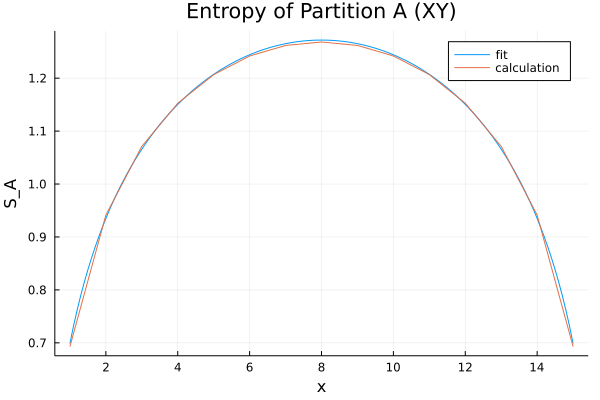

In [17]:
using Plots

plot(title = "Entropy of Partition A (XY)", xlabel = "x", ylabel = "S_A")

plot!(x_range_cont,fit_XY_cont,label = "fit")
display(plot!(x_range,entropies_XY,label = "calculation"))

In [ ]:
png("NewPlots/SA_XY")

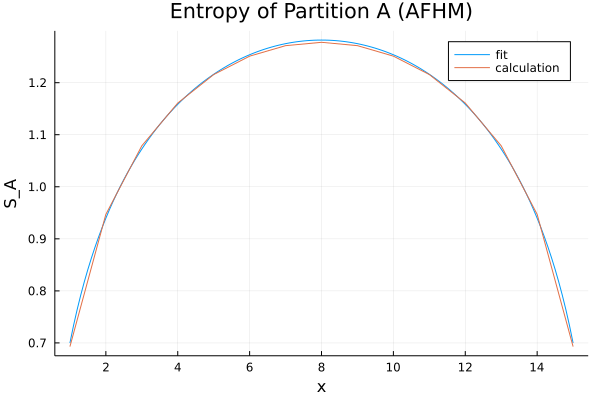

In [18]:
using Plots

plot(title = "Entropy of Partition A (AFHM)", xlabel = "x", ylabel = "S_A")

plot!(x_range_cont,fit_Heis_cont,label = "fit")
display(plot!(x_range,entropies_Heis,label = "calculation"))

In [ ]:
png("NewPlots/SA_AFHM")

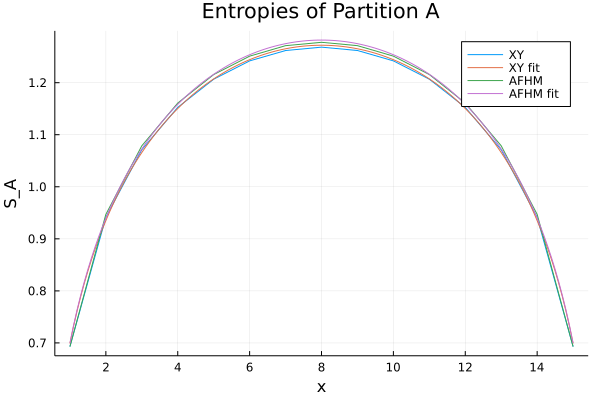

In [19]:
using Plots

plot(title = "Entropies of Partition A", xlabel = "x", ylabel = "S_A")

plot!(x_range,entropies_XY,label = "XY")
plot!(x_range_cont,fit_XY_cont,label = "XY fit")
plot!(x_range,entropies_Heis,label = "AFHM")
plot!(x_range_cont,fit_Heis_cont,label = "AFHM fit")


In [ ]:
png("NewPlots/SA_XY_AFHM")

Away from these parameters

In [ ]:
using Arpack
N_spins = 16
x_range = range(1,N_spins-1,step = 1)
Away,mags = Hamiltonian_Prob2(N_spins,1,2)
entropies_Away = zeros(length(x_range))
val_Away,vec_Away = eigs(Away, nev = 1, which=:SR)

In [ ]:
for x in x_range
    entropies_Away[x] = entropy(vec_Away,N_spins,x)
end

In [ ]:
save_object("NewData/entropies_Delta_J_05",entropies_Away)

In [21]:
entropies_Away = load_object("NewData/entropies_Delta_J_05");

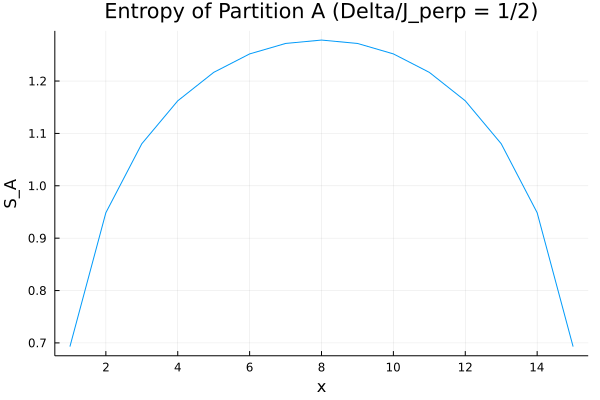

In [22]:
using Plots

plot(title = "Entropy of Partition A (Delta/J_perp = 1/2)", xlabel = "x", ylabel = "S_A")

display(plot!(x_range,entropies_Away,legend = false))

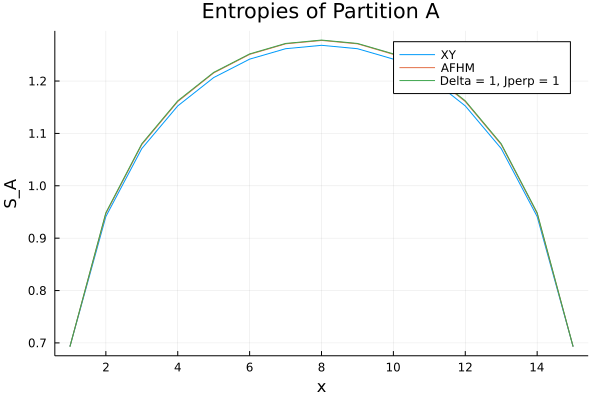

In [23]:
using Plots

plot(title = "Entropies of Partition A", xlabel = "x", ylabel = "S_A")

plot!(x_range,entropies_XY,label = "XY");
plot!(x_range,entropies_Heis,label = "AFHM");
display(plot!(x_range,entropies_Away,label = "Delta = 1, Jperp = 1"))

In [ ]:
png("NewPlots/SA_delta_J_1_2")

In [24]:
model_12(t,p) = p[1].+ (p[2]/3).*log.(((L/pi).*sin.((pi.*t)./L)).+0.001)
tdata = x_range
ydata_Away1 = entropies_Away
p0 = [1.,1.]
fit_Away1 = curve_fit(model_12,tdata,ydata_Away1,p0)
params_Away1 = fit_Away1.param



2-element Vector{Float64}:
 0.7024098605795406
 1.0698673221899546

In [25]:
println(params_Away1)
println(standard_errors(fit_Away1))

[0.7024098605795406, 1.0698673221899546]
[0.0034332717445908654, 0.00829376254242571]
